In [ ]:
## Analisis de componentes PCA u otros 

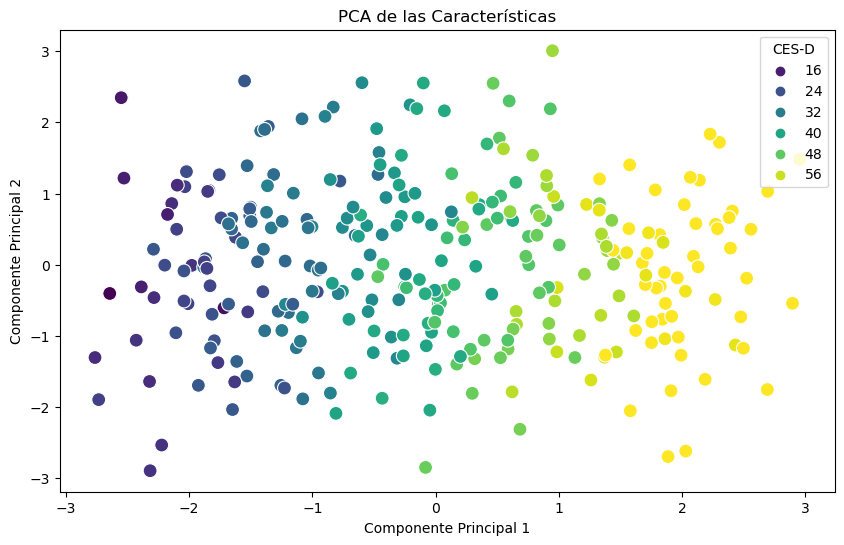

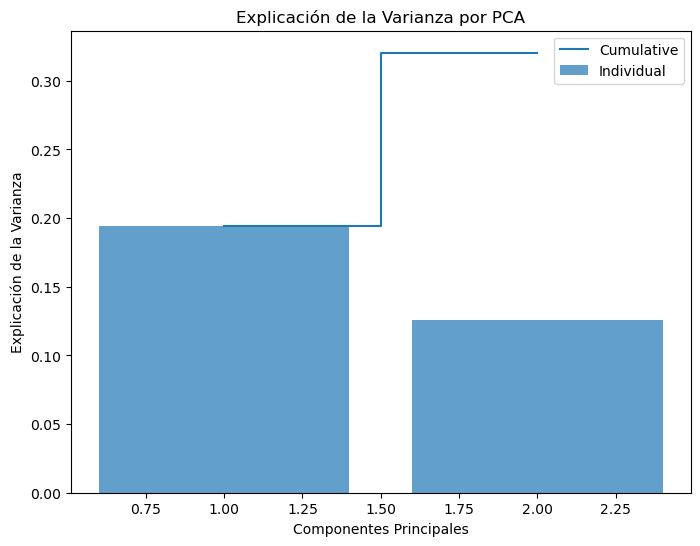

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Cargar los datos desde el archivo Excel
data = pd.read_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/base_datos_sinteticChatGPT.xlsx')

# Separar las características y la variable objetivo, excluyendo la columna 'numerousuario'
X = data.drop(columns=['numerousuario', 'CES-D'])  # Ajuste aquí para eliminar la columna 'numerousuario'
y = data['CES-D']

# Manejar los valores faltantes usando SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['CES-D'] = y

# Visualización de los componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='CES-D', data=pca_df, palette='viridis', s=100)
plt.title('PCA de las Características')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# Visualización de la varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative')
plt.ylabel('Explicación de la Varianza')
plt.xlabel('Componentes Principales')
plt.title('Explicación de la Varianza por PCA')
plt.legend(loc='best')
plt.show()


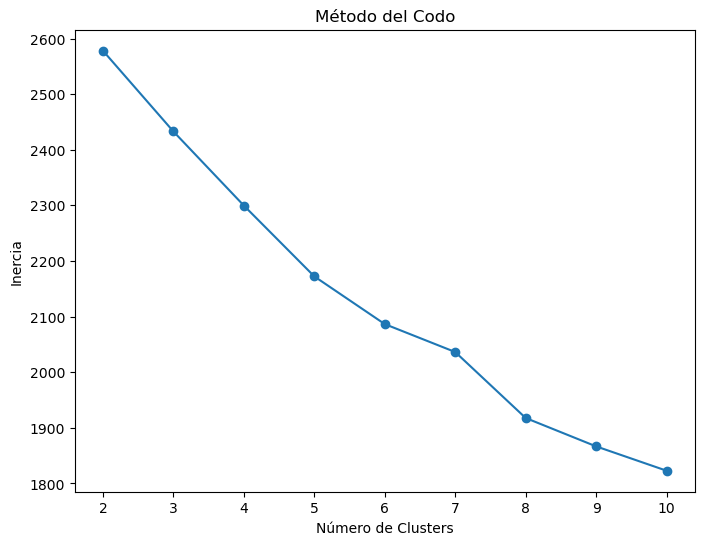

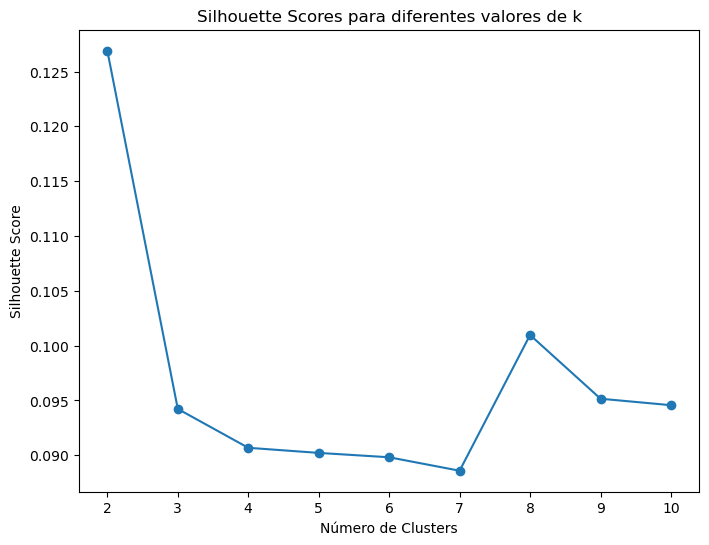

Mejor número de clusters basado en el Silhouette Score: 2


/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


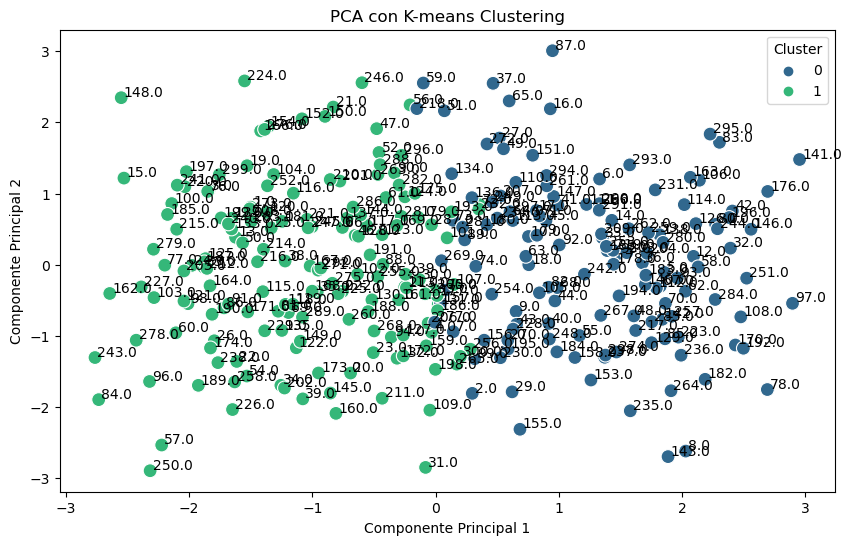

Cluster 0: [2, 5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 27, 29, 32, 33, 36, 37, 40, 41, 42, 43, 44, 45, 48, 49, 51, 55, 58, 59, 62, 63, 64, 65, 67, 68, 70, 71, 73, 74, 75, 78, 79, 80, 82, 83, 85, 87, 89, 92, 93, 95, 97, 99, 105, 106, 108, 110, 111, 112, 113, 114, 126, 129, 134, 136, 138, 140, 141, 142, 143, 146, 147, 151, 153, 155, 156, 157, 158, 163, 165, 170, 176, 178, 180, 182, 183, 184, 192, 194, 195, 196, 203, 204, 207, 209, 217, 218, 219, 223, 228, 230, 231, 234, 235, 236, 237, 242, 244, 248, 249, 251, 253, 254, 257, 259, 261, 262, 264, 266, 267, 269, 270, 272, 274, 277, 280, 281, 284, 285, 290, 291, 293, 294, 295, 297, 298]
Cluster 1: [1, 3, 4, 11, 13, 15, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 34, 35, 38, 39, 46, 47, 50, 52, 53, 54, 56, 57, 60, 61, 66, 69, 72, 76, 77, 81, 84, 86, 88, 90, 91, 94, 96, 98, 100, 101, 102, 103, 104, 107, 109, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131, 132, 133, 135, 137, 139, 144, 145, 148, 149, 150, 152, 154, 159,

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cargar los datos desde el archivo Excel
data = pd.read_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/base_datos_sinteticChatGPT.xlsx')

# Separar las características y la variable objetivo, excluyendo la columna 'numerousuario'
X = data.drop(columns=['numerousuario', 'CES-D'])
y = data['CES-D']

# Manejar los valores faltantes usando SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['CES-D'] = y
pca_df['numerousuario'] = data['numerousuario']  # Añadir las etiquetas de los usuarios

# Método del codo para encontrar el número óptimo de clusters
inertia = []
silhouette_scores = []
range_n_clusters = list(range(2, 11))
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, clusters))

# Graficar el Método del codo
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

# Graficar el Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferentes valores de k')
plt.show()

# Elegir el mejor k basado en el Silhouette Score
best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f'Mejor número de clusters basado en el Silhouette Score: {best_k}')

# Aplicar K-means clustering con el mejor número de clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
pca_df['Cluster'] = clusters

# Visualización de los componentes principales con elipses alrededor de los grupos
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('PCA con K-means Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Añadir etiquetas a los puntos
for i, point in pca_df.iterrows():
    plt.text(point['PC1']+0.02, point['PC2']+0.02, str(point['numerousuario']), horizontalalignment='left', size='medium', color='black')

plt.show()

# Crear listas de muestras por cluster
clusters_dict = {}
for cluster in np.unique(clusters):
    clusters_dict[cluster] = pca_df[pca_df['Cluster'] == cluster]['numerousuario'].tolist()

# Imprimir la lista de muestras por cluster
for cluster, samples in clusters_dict.items():
    print(f"Cluster {cluster}: {samples}")


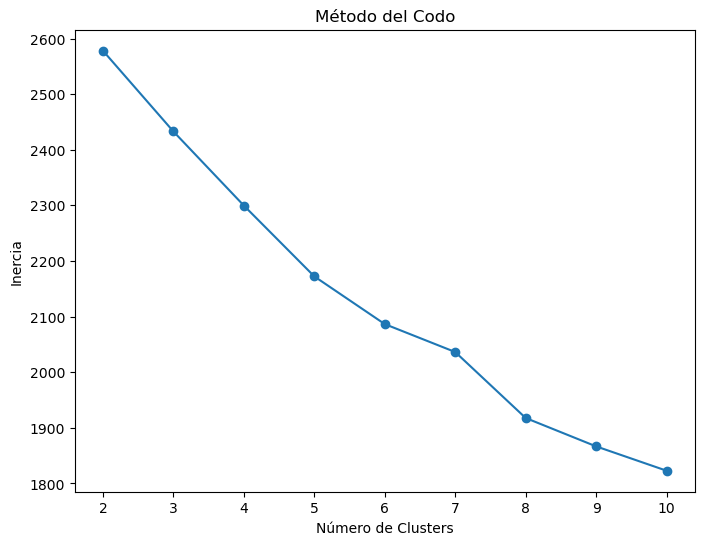

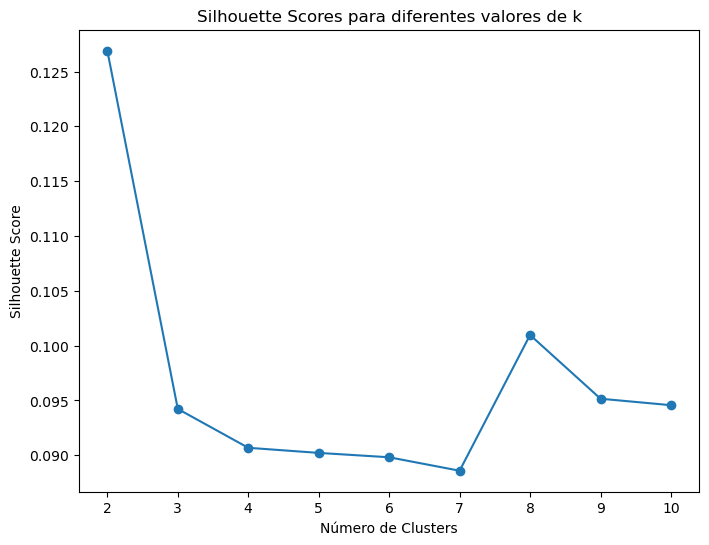

Mejor número de clusters basado en el Silhouette Score: 2


/var/folders/tk/2p1f8x557x79x9qjd90_gcdh0000gn/T/ipykernel_17142/2133709580.py:80: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
/var/folders/tk/2p1f8x557x79x9qjd90_gcdh0000gn/T/ipykernel_17142/2133709580.py:80: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


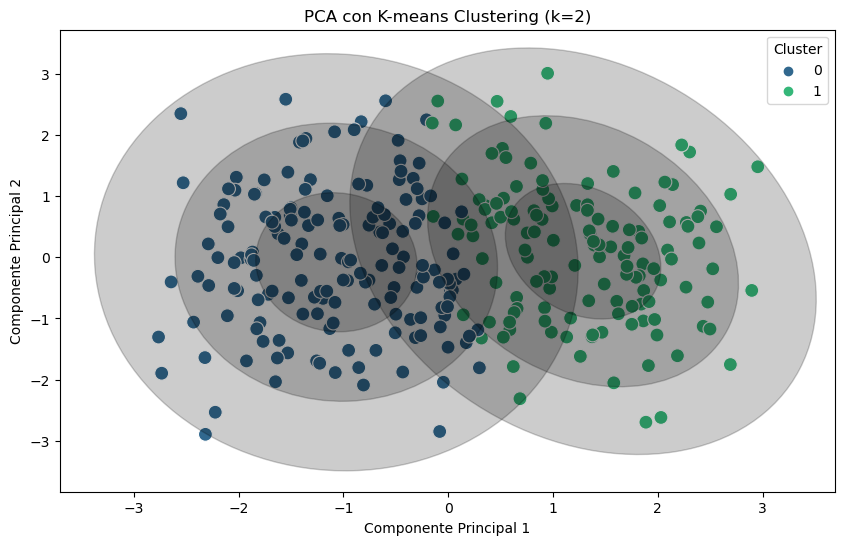

Cluster 0: [1, 2, 3, 4, 11, 13, 15, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 34, 35, 38, 39, 46, 47, 50, 52, 53, 54, 56, 57, 60, 61, 66, 69, 75, 76, 77, 81, 84, 86, 88, 90, 91, 94, 96, 98, 100, 102, 103, 104, 107, 109, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131, 132, 133, 135, 137, 139, 144, 145, 148, 149, 150, 152, 154, 157, 159, 160, 161, 162, 164, 166, 167, 168, 169, 171, 172, 173, 174, 175, 177, 181, 185, 186, 187, 188, 189, 190, 191, 193, 197, 198, 199, 200, 201, 202, 205, 206, 208, 210, 211, 212, 213, 214, 215, 216, 220, 221, 222, 224, 225, 226, 227, 229, 233, 238, 239, 240, 241, 243, 245, 246, 247, 250, 252, 255, 256, 258, 260, 263, 265, 268, 269, 271, 273, 275, 276, 277, 278, 279, 282, 283, 286, 287, 288, 289, 292, 296, 299, 300]
Cluster 1: [5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 27, 29, 32, 33, 36, 37, 40, 41, 42, 43, 44, 45, 48, 49, 51, 55, 58, 59, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 78, 79, 80, 82, 83, 85, 87, 89, 92, 93, 95, 97, 99,

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse

# Cargar los datos desde el archivo Excel
data = pd.read_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/base_datos_sinteticChatGPT.xlsx')

# Separar las características y la variable objetivo, excluyendo la columna 'numerousuario'
X = data.drop(columns=['numerousuario', 'CES-D'])
y = data['CES-D']

# Manejar los valores faltantes usando SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['CES-D'] = y
pca_df['numerousuario'] = data['numerousuario']  # Añadir las etiquetas de los usuarios

# Método del codo para encontrar el número óptimo de clusters
inertia = []
silhouette_scores = []
range_n_clusters = list(range(2, 11))
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, clusters))

# Graficar el Método del codo
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

# Graficar el Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferentes valores de k')
plt.show()

# Elegir el mejor k basado en el Silhouette Score
best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f'Mejor número de clusters basado en el Silhouette Score: {best_k}')

# Aplicar K-means clustering con el mejor número de clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
pca_df['Cluster'] = clusters

# Función para dibujar elipses alrededor de los grupos
def draw_ellipse(position, covariance, ax, **kwargs):
    """Dibuja una elipse con la posición y covarianza dadas"""
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

# Visualización de los componentes principales con elipses alrededor de los grupos
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('PCA con K-means Clustering (k=2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Añadir elipses alrededor de los grupos
for cluster in np.unique(clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    if len(cluster_data) > 1:
        covariance = np.cov(cluster_data[['PC1', 'PC2']], rowvar=False)
        draw_ellipse(cluster_data[['PC1', 'PC2']].mean(), covariance, plt.gca(), alpha=0.2, color='black')

plt.show()

# Crear listas de muestras por cluster
clusters_dict = {}
for cluster in np.unique(clusters):
    clusters_dict[cluster] = pca_df[pca_df['Cluster'] == cluster]['numerousuario'].tolist()

# Imprimir la lista de muestras por cluster
for cluster, samples in clusters_dict.items():
    print(f"Cluster {cluster}: {samples}")

# Crear una nueva DataFrame con las muestras y sus clusters
clustered_data = data[['numerousuario', 'CES-D']].copy()
clustered_data['Cluster'] = clusters

# Exportar a un archivo Excel
clustered_data.to_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/clustered_data_k2.xlsx', index=False)
print("El archivo Excel ha sido guardado como 'clustered_data_k2.xlsx' en la ruta especificada.")


Precisión del Decision Tree: 0.18


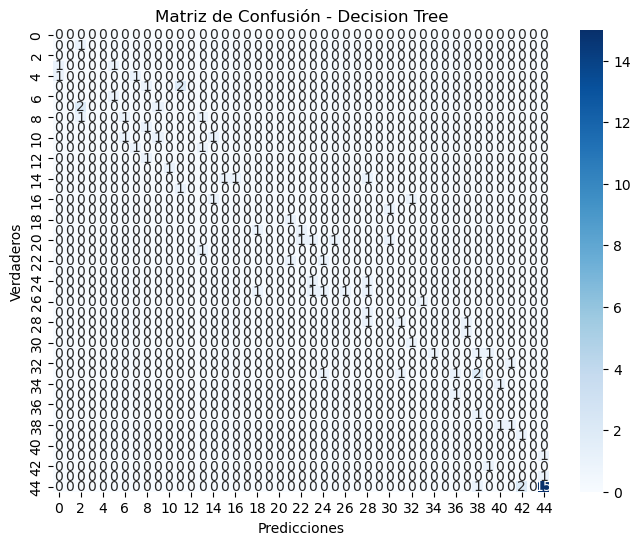

Precisión del Random Forest: 0.20


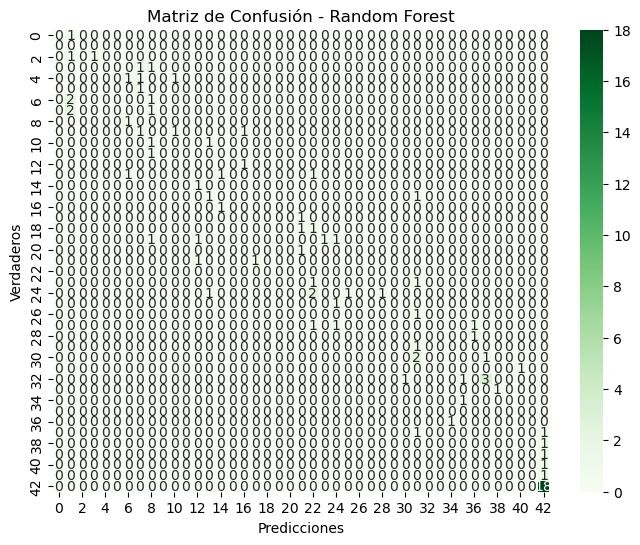

Reporte de Clasificación - Decision Tree
              precision    recall  f1-score   support

          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         3
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         3
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         3
          27       0.00      0.00      0.00         2
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         3
          31       0.00      0.00      0.00         1
          32       0.00      0.00      0

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-p

ValueError: Length of values (11) does not match length of index (12)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Cargar los datos desde el archivo Excel
data = pd.read_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/base_datos_sinteticChatGPT.xlsx')

# Separar las características y la variable objetivo
X = data.drop(columns=['numerousuario', 'CES-D'])
y = data['CES-D']

# Manejar los valores faltantes usando SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Crear y entrenar un modelo de Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predecir y calcular la precisión del modelo de Decision Tree
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f'Precisión del Decision Tree: {dt_accuracy:.2f}')

# Matriz de confusión para Decision Tree
dt_cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Decision Tree')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

# Crear y entrenar un modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predecir y calcular la precisión del modelo de Random Forest
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Precisión del Random Forest: {rf_accuracy:.2f}')

# Matriz de confusión para Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

# Reporte de clasificación para ambos modelos
print('Reporte de Clasificación - Decision Tree')
print(classification_report(y_test, dt_predictions))

print('Reporte de Clasificación - Random Forest')
print(classification_report(y_test, rf_predictions))

# Importancia de características para Random Forest
importances = rf_model.feature_importances_
indices = pd.Series(importances, index=data.drop(columns=['numerousuario', 'CES-D']).columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
indices.plot(kind='bar')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=data.drop(columns=['numerousuario', 'CES-D']).columns, class_names=['0', '1'])
plt.title('Árbol de Decisión')
plt.show()


Precisión del Random Forest: 0.99


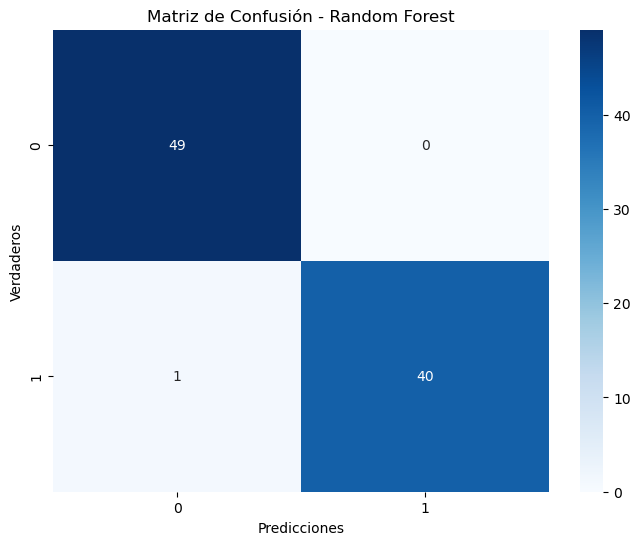

Reporte de Clasificación - Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      0.98      0.99        41

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



ValueError: Length of values (11) does not match length of index (12)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Cargar los datos desde el archivo Excel
data = pd.read_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/base_datos_sinteticChatGPT.xlsx')

# Separar las características y la variable objetivo, incluyendo la columna Cluster como objetivo
X = data.drop(columns=['numerousuario', 'Cluster'])
y = data['Cluster']

# Manejar los valores faltantes usando SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Crear y entrenar un modelo de Random Forest supervisado
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predecir y calcular la precisión del modelo de Random Forest
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Precisión del Random Forest: {rf_accuracy:.2f}')

# Matriz de confusión para Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

# Reporte de clasificación para Random Forest
print('Reporte de Clasificación - Random Forest')
print(classification_report(y_test, rf_predictions))

# Importancia de características para Random Forest
importances = rf_model.feature_importances_
indices = pd.Series(importances, index=data.drop(columns=['numerousuario', 'Cluster']).columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
indices.plot(kind='bar')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()


Precisión del Decision Tree: 0.94


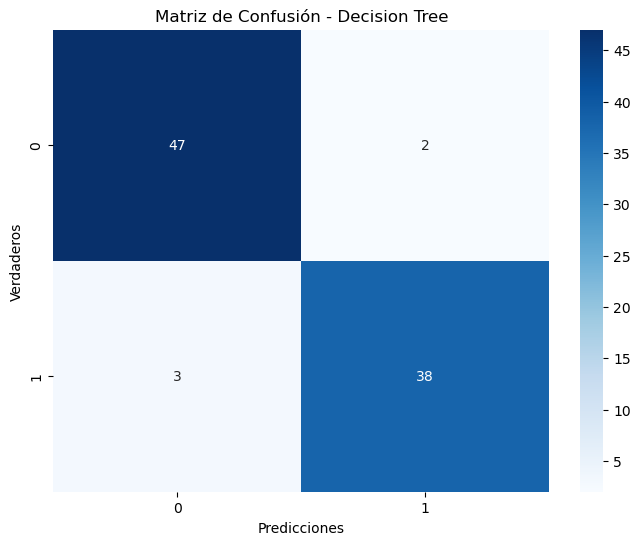

Reporte de Clasificación - Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        49
           1       0.95      0.93      0.94        41

    accuracy                           0.94        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.94      0.94      0.94        90



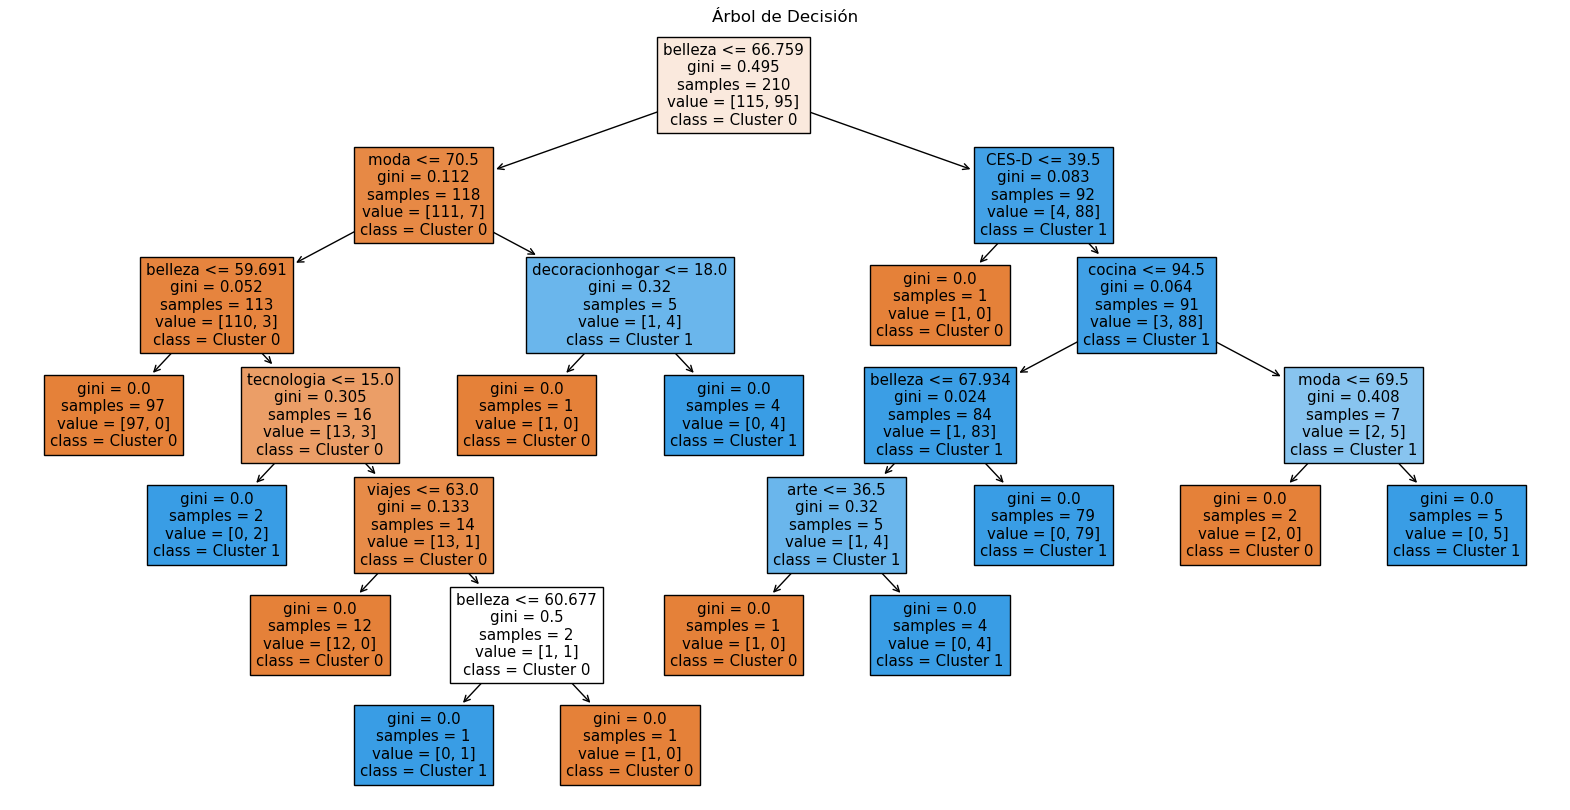

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Cargar los datos desde el archivo Excel
data = pd.read_excel('/Users/christiandujak/Documents/Master_NextEdu/TFM/base_datos_sinteticChatGPT.xlsx')

# Separar las características y la variable objetivo, incluyendo la columna Cluster como objetivo
X = data.drop(columns=['numerousuario', 'Cluster'])
y = data['Cluster']

# Manejar los valores faltantes usando SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Crear y entrenar un modelo de Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predecir y calcular la precisión del modelo de Decision Tree
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f'Precisión del Decision Tree: {dt_accuracy:.2f}')

# Matriz de confusión para Decision Tree
dt_cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Decision Tree')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

# Reporte de clasificación para Decision Tree
print('Reporte de Clasificación - Decision Tree')
print(classification_report(y_test, dt_predictions))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=data.drop(columns=['numerousuario', 'Cluster']).columns, class_names=['Cluster 0', 'Cluster 1'])
plt.title('Árbol de Decisión')
plt.show()
